In [43]:
import numpy as np

import torch
from torch import nn
from torch import optim

import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import clear_output

In [44]:
import sys
sys.path.append('..')

from samplers_new import mala, i_sir, ex2_mcmc

In [45]:
from mnist_2d_experiments.models import GeneratorMNIST, DiscriminatorMNIST

In [46]:
device = 'cpu'

In [47]:
gen_mnist = GeneratorMNIST(2)
gen_mnist.to(device)

discr_mnist = DiscriminatorMNIST()
discr_mnist.to(device)

prior_mnist = torch.distributions.MultivariateNormal(torch.zeros(2).to(device), torch.eye(2).to(device))

In [48]:
gen_mnist.load_state_dict(torch.load('./weights/vanilla_gan_2d.ckpt')[0])
discr_mnist.load_state_dict(torch.load('./weights/vanilla_gan_2d.ckpt')[1])
gen_mnist.eval()
discr_mnist.eval();

In [49]:
def get_energy(z):
    return (-discr_mnist(gen_mnist(z)).reshape(z.shape[0]) - prior_mnist.log_prob(z))

def log_target_dens(z, detach=True, batch_size=128):
    """
    returns the value of a target density - mixture of the 3 gaussians 
    """
    res = []
    for i in range(z.shape[0] // batch_size + (1 if z.shape[0] % batch_size else 0)):
        cur_res = -get_energy(z[batch_size * i: batch_size * (i+1)])
        
        if detach:
            cur_res = cur_res.detach()
        
        res.append(cur_res)
    
    return torch.cat(res)

### Put parameters of the target density

In [52]:
seed = 42
torch.manual_seed(42)

lat_size = 2
N_samples = 3

x0 = torch.randn(N_samples, lat_size).to(device)

100%|██████████| 79/79 [00:42<00:00,  1.85it/s]


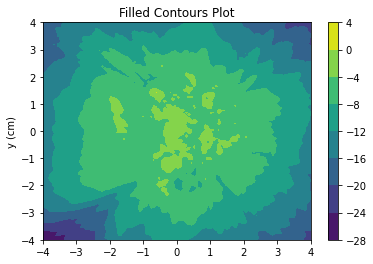

In [53]:
N_pts = 100
xlist = np.linspace(-2*a, 2*a, N_pts)
ylist = np.linspace(-2*a, 2*a, N_pts)
X, Y = np.meshgrid(xlist, ylist)
points = np.zeros((X.shape[0],X.shape[1], 2),dtype=float)
points[:, :, 0] = X
points[:, :, 1] = Y

points = points.reshape(-1, 2)

batch_size = 128

dens_vals = []
for i in tqdm.tqdm(range(points.shape[0] // batch_size + (1 if points.shape[0] % batch_size else 0))):
    z = torch.FloatTensor(points[i * batch_size: (i + 1) * batch_size]).to(device)
    dens_vals.append(-get_energy(z).detach().cpu().numpy())

dens_vals = np.concatenate(dens_vals).reshape(N_pts, N_pts)

fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, dens_vals)
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('Filled Contours Plot')
#ax.set_xlabel('x (cm)')
ax.set_ylabel('y (cm)')
plt.show()

# I-SIR

In [54]:
from torch.distributions import MultivariateNormal

sigma_isir = 3.0
isir_proposal = MultivariateNormal(
    torch.zeros(lat_size).to(device), 
    (sigma_isir ** 2) * torch.eye(lat_size).to(device))

N_particles = 10
N_steps = 100
np.random.seed(42)

Samples_isir = i_sir(log_target_dens=log_target_dens, x0=x0, N_steps=N_steps, N_part=N_particles, isir_proposal=isir_proposal)

energies_isir = -log_target_dens(Samples_isir.reshape(-1, lat_size)).reshape(N_samples, N_steps + 1).cpu()

100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


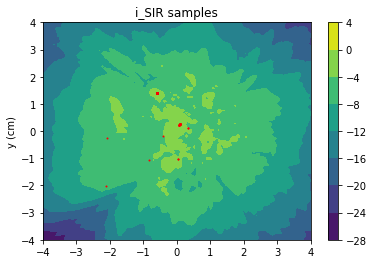

In [55]:
fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, dens_vals)
fig.colorbar(cp) # Add a colorbar to a plot
ax.scatter(Samples_isir[0, :, 0], Samples_isir[0, :, 1], s=1, c='r')
ax.set_title('i_SIR samples')
#ax.set_xlabel('x (cm)')
ax.set_ylabel('y (cm)')
plt.show()

# MALA 

In [56]:
N_steps = 100

gamma = 2e-2
mala_iters = 3

stats = {'n_accepts': 0}

Samples_mala = mala(log_target_dens=log_target_dens, x0=x0, N_steps=N_steps, gamma=gamma, mala_iters=mala_iters, stats=stats)

energies_mala = -log_target_dens(Samples_mala.reshape(-1, lat_size)).reshape(N_samples, N_steps + 1).cpu()

100%|██████████| 100/100 [00:25<00:00,  3.92it/s]


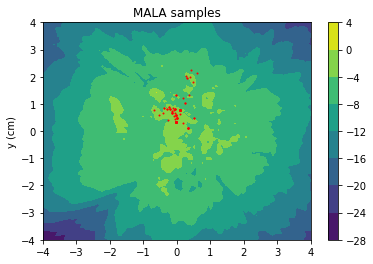

In [57]:
fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, dens_vals)
fig.colorbar(cp) # Add a colorbar to a plot
ax.scatter(Samples_mala[0, :, 0],Samples_mala[0, :, 1], s=1, c='r')
ax.set_title('MALA samples')
#ax.set_xlabel('x (cm)')
ax.set_ylabel('y (cm)')
plt.show()

In [58]:
print(stats['n_accepts'])

227.0


# Ex2MCMC

In [59]:
N_steps = 100

sigma_isir = 3.0
isir_proposal = MultivariateNormal(
    torch.zeros(lat_size).to(device), 
    (sigma_isir ** 2) * torch.eye(lat_size).to(device))

N_particles = 10

gamma = 2e-2
mala_iters = 3

stats = {'n_accepts': 0}

Samples_ex2 = ex2_mcmc(log_target_dens=log_target_dens, x0=x0, N_steps=N_steps, 
                       N_part=N_particles, isir_proposal=isir_proposal ,
                       gamma=gamma, mala_iters=mala_iters, stats=stats)

energies_ex2 = -log_target_dens(Samples_ex2.reshape(-1, lat_size)).reshape(N_samples, N_steps + 1).cpu()

100%|██████████| 100/100 [00:38<00:00,  2.62it/s]


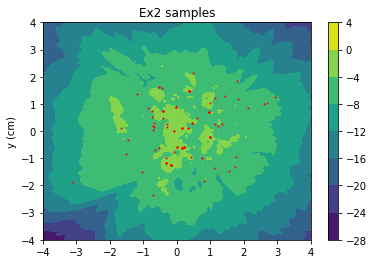

In [60]:
fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, dens_vals)
fig.colorbar(cp) # Add a colorbar to a plot
ax.scatter(Samples_ex2[0, :,0],Samples_ex2[0, :,1], s=1, c='r')
ax.set_title('Ex2 samples')
#ax.set_xlabel('x (cm)')
ax.set_ylabel('y (cm)')
plt.show()

### Plot all 3 pictures together

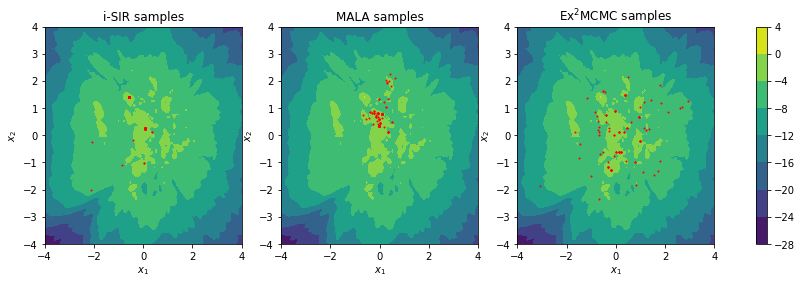

In [61]:
fig,ax = plt.subplots(1,3,figsize=(15,4))
im = ax[0].contourf(X, Y, dens_vals)
im = ax[1].contourf(X, Y, dens_vals)
im = ax[2].contourf(X, Y, dens_vals)
fig.colorbar(im, ax=ax.flat) # Add a colorbar to a plot
#i-sir plots
ax[0].scatter(Samples_isir[0, :,0],Samples_isir[0,:,1], s=1, c='r')
ax[0].set_title('i-SIR samples')
ax[0].set_xlabel('$x_1$')
ax[0].set_ylabel('$x_2$')
#mala samples
ax[1].scatter(Samples_mala[0,:,0],Samples_mala[0,:,1], s=1, c='r')
ax[1].set_title('MALA samples')
ax[1].set_xlabel('$x_1$')
ax[1].set_ylabel('$x_2$')
#ex2-mcmc samples
ax[2].scatter(Samples_ex2[0,:,0],Samples_ex2[0,:,1], s=1, c='r')
ax[2].set_title('Ex$^2$MCMC samples')
ax[2].set_xlabel('$x_1$')
ax[2].set_ylabel('$x_2$')
plt.savefig("./figs/vanilla_gan_2d_lat_samples.pdf", format="pdf", bbox_inches="tight") 
plt.show()

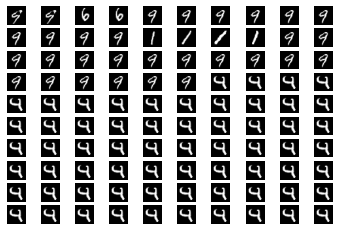

In [62]:
sampled_mnist = gen_mnist(torch.FloatTensor(Samples_isir[0, :, :]))

for i in range(100):
    plt.subplot(10, 10, i + 1)
    plt.axis('off')
    plt.imshow(sampled_mnist[i, 0].detach().cpu().numpy(), cmap='gray')
plt.savefig("./figs/js_gan_samples_isir.pdf", format="pdf", bbox_inches="tight")

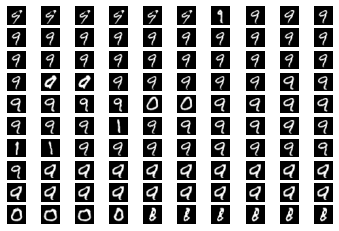

In [63]:
sampled_mnist = gen_mnist(torch.FloatTensor(Samples_mala[0, :, :]))

for i in range(100):
    plt.subplot(10, 10, i + 1)
    plt.axis('off')
    plt.imshow(sampled_mnist[i, 0].detach().cpu().numpy(), cmap='gray')
plt.savefig("./figs/js_gan_samples_mala.pdf", format="pdf", bbox_inches="tight")

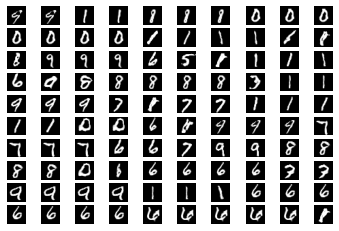

In [64]:
sampled_mnist = gen_mnist(torch.FloatTensor(Samples_ex2[0, :, :]))

for i in range(100):
    plt.subplot(10, 10, i + 1)
    plt.axis('off')
    plt.imshow(sampled_mnist[i, 0].detach().cpu().numpy(), cmap='gray')
plt.savefig("./figs/js_gan_samples_ex2.pdf", format="pdf", bbox_inches="tight")